In [1]:
import os, sys
sys.path.append('../src/')

from copulae1 import *

import json
with open('../src/configs/config_coingecko_future_v3_MM.json','r') as file:
    config = json.load(file)
config
data_name = config['data_name']
calibration_method  = config['calibration_method']
OHR = pd.read_hdf('../results/'+data_name +'/'+calibration_method+'/best_h.h5')
if not os.path.exists("../results/" + data_name + "/MLE/reports"):
	print("Create new folder for results")
	os.mkdir("../results/" + data_name + "/MLE/reports")
	os.mkdir("../results/" + data_name + "/MM/reports")
    
if calibration_method == "MLE":
    report_path = "../results/" + data_name + "/MLE/reports/"
    result_path = "../results/" + data_name + "/MLE/"
elif calibration_method == "MM":
    report_path = "../results/" + data_name + "/MM/reports/"
    result_path = "../results/" + data_name + "/MM/"
    
data_path = "../processed_data/"+data_name+'/test/'

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
natp_path = '../_mathematica/data/'
natp_ls = os.listdir(natp_path)
natp_h = [l for l in natp_ls if l.endswith('_h.csv')]
file_names = [l.replace('_h','') for l in natp_h]
OHR_combined = []
for i in range(len(natp_h)):
    print(i)
    _natp_h = pd.DataFrame(open(natp_path+natp_h[i], 'r').readlines())
    _natp_h = _natp_h.iloc[1:7,:]
    file_name = natp_h[i].replace('_h','')
    for i in range(len(_natp_h)):
        _natp_h.iloc[i,0] = np.float32(_natp_h.iloc[i,0].replace('\n',''))
    _natp_h.columns = ['NIG_factor']
    _natp_h.index = ['Variance', 'VaR q=0.01', 'VaR q=0.05', 'ES q=0.01', 'ES q=0.05', 'ERM k=10']
    _natp_h = _natp_h.T
    
    OHR_combined.append(OHR.loc[:,file_name].append(_natp_h))
OHR = pd.concat(OHR_combined, axis=1, keys=file_names).dropna(axis=1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74


In [3]:
Copula_names = ['Gaussian', 't_Copula', 'Clayton', 'Frank', 'Gumbel', 'Plackett', 'Gauss Mix Indep', 'NIG_factor']
# Copula_names = ['Gaussian', 't_Copula', 'Clayton', 'Frank', 'Gumbel', 'Plackett', 'Gauss Mix Indep']

OHR = OHR.loc[Copula_names,:]

In [4]:
temp = []
for C in Copula_names:
    hs_by_Copula = OHR.loc[C:C,:].melt()
    hs_by_Copula.columns = ['file_name', 'risk_measure', 'OHR']
    hs_by_Copula.loc[:, 'copula'] = C
    temp.append(hs_by_Copula)

OHR_to_math = pd.concat(temp, axis=0)

In [5]:
files = np.unique(OHR_to_math.file_name)
risk_measures = np.unique(OHR_to_math.risk_measure)

In [6]:
# C = Copula_names[0]
results = {}

for C in Copula_names:
    for rm in risk_measures:
        id_C = OHR_to_math.copula == C
        id_rm = OHR_to_math.risk_measure == rm


        df = OHR_to_math.loc[id_C&id_rm, :]
        df.reset_index(inplace=True, drop=True)

        rh_arr = []
        rs_arr = []
        rf_arr = []

        Date_arr = []

        for i in range(len(df)):
            h = df.iloc[i,:].OHR
            test = pd.read_csv(data_path+df.iloc[i,:].file_name)
            Date = test.Date
            rs = test.loc[:, 'log return bitcoin']
            rf = test.loc[:, 'log return future']
            rh = rs - h*rf
            rh_arr.append(rh)
            Date_arr.append(Date)

            rs_arr.append(rs)
            rf_arr.append(rf)
            
        rh_df = pd.DataFrame({'Date':np.array(Date_arr).reshape((-1)), 'rh':np.array(rh_arr).reshape((-1))})
        rs_df = pd.DataFrame({'Date':np.array(Date_arr).reshape((-1)), 'rs':np.array(rs_arr).reshape((-1))})
        rf_df = pd.DataFrame({'Date':np.array(Date_arr).reshape((-1)), 'rf':np.array(rf_arr).reshape((-1))})
        
        rh_df.Date = pd.to_datetime(rh_df.Date)
        rs_df.Date = pd.to_datetime(rs_df.Date)
        rf_df.Date = pd.to_datetime(rf_df.Date)
        
        # sort Date to make sure the cumulative sum is correct (sort from old data to new data)
        rh_df = rh_df.sort_values('Date', ascending=True).reset_index( drop=True)
        rs_df = rs_df.sort_values('Date', ascending=True).reset_index( drop=True)
        rf_df = rf_df.sort_values('Date', ascending=True).reset_index( drop=True)
      
        rh_df.loc[:,'cumsum'] = np.cumsum(rh_df.rh)
        rs_df.loc[:,'cumsum'] = np.cumsum(rs_df.rs)
        rf_df.loc[:,'cumsum'] = np.cumsum(rf_df.rf)
        
        investment = 1
        income_rh = investment*np.exp(rh_df.loc[:,'cumsum'])
        income_rs = investment*np.exp(rs_df.loc[:,'cumsum'])
        income_rf = investment*np.exp(rf_df.loc[:,'cumsum'])
    
        results[(C, rm)] = income_rh

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


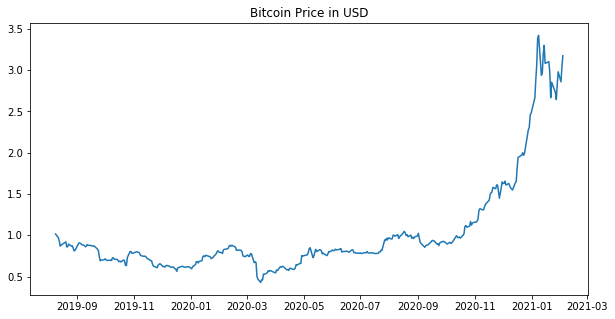

In [7]:
plt.figure(figsize=(10,5))
plt.plot(rh_df.Date, income_rs, label='Long Bitcoin')
plt.title("Bitcoin Price in USD")
plt.savefig('plots/bitcoin_price.png', transparent=True)

In [8]:
rs_df

,Date,rs,cumsum
0,2019-08-09,0.015356,0.015356
1,2019-08-12,-0.045005,-0.029649
2,2019-08-13,-0.044405,-0.074054
3,2019-08-14,-0.066025,-0.140080
4,2019-08-15,0.013129,-0.126951
...,...,...,...
370,2021-01-28,0.067181,1.039722
371,2021-01-29,0.052253,1.091974
372,2021-02-01,-0.041523,1.050452
373,2021-02-02,0.059664,1.110116


/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


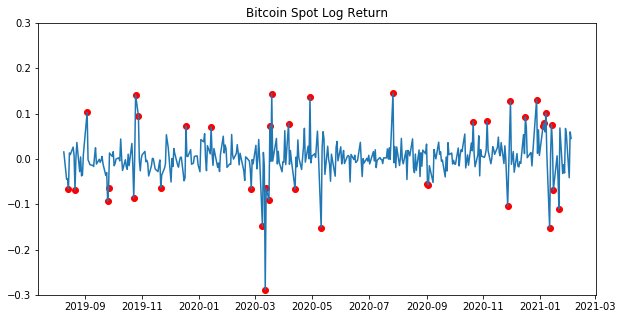

In [10]:
plt.figure(figsize=(10,5))
plt.plot(rs_df.Date, rs_df.rs)

up_i = rs_df.rs > np.quantile(rs_df.rs, 0.95)
plt.scatter(rs_df.Date.loc[up_i], rs_df.rs.loc[up_i], color='r')

low_i = rs_df.rs < np.quantile(rs_df.rs, 0.05)
plt.scatter(rs_df.Date.loc[low_i], rs_df.rs.loc[low_i], color='r')

plt.ylim((-0.3,0.3))


plt.title('Bitcoin Spot Log Return')
plt.savefig('plots/bitcoin_return.png', transparent=True)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


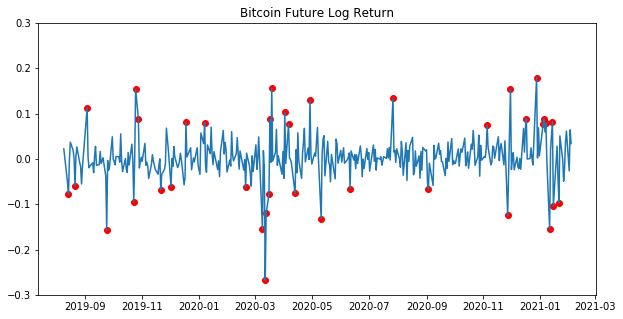

In [11]:
plt.figure(figsize=(10,5))
plt.plot(rf_df.Date, rf_df.rf)

up_i = rf_df.rf > np.quantile(rf_df.rf, 0.95)
plt.scatter(rf_df.Date.loc[up_i], rf_df.rf.loc[up_i], color='r')

low_i = rf_df.rf < np.quantile(rf_df.rf, 0.05)
plt.scatter(rf_df.Date.loc[low_i], rf_df.rf.loc[low_i], color='r')

plt.ylim((-0.3,0.3))

plt.title('Bitcoin Future Log Return')
plt.savefig('plots/future_return.png', transparent=True)

In [20]:
pd.DataFrame(results)

Gaussian                                                      t_Copula  \
     ERM k=10 ES q=0.01 ES q=0.05 VaR q=0.01 VaR q=0.05  Variance  ERM k=10   
0    0.994953  0.996321  0.995026   0.994630   0.994352  0.995203  0.995330   
1    0.981109  0.980410  0.981071   0.981274   0.981416  0.980981  0.980916   
2    0.985171  0.981259  0.984962   0.986098   0.986896  0.984456  0.984092   
3    0.990739  0.982055  0.990272   0.992801   0.994578  0.989147  0.988338   
4    1.005638  0.996703  1.005157   1.007760   1.009589  1.004000  1.003167   
..        ...       ...       ...        ...        ...       ...       ...   
370  1.105326  0.955511  1.078853   1.082387   1.208243  1.106272  1.099158   
371  1.103193  0.948528  1.074862   1.074593   1.211281  1.103620  1.097267   
372  1.083226  0.933523  1.056212   1.057544   1.187092  1.083863  1.077310   
373  1.086539  0.931108  1.057479   1.054927   1.196262  1.086647  1.080842   
374  1.103503  0.942839  1.072942   1.068282   1.217913  1.103329  1.097844   

                                    ... Gauss Mix Indep                        \
    ES q=0.01 ES q=0.05 VaR q=0.01  ...       ES q=0.05 VaR q=0.01 VaR q=0.05   
0    0.997147  0.995961   0.996645  ...        0.997840   1.003938   0.994927   
1    0.979990  0.980594   0.980246  ...        0.979637   0.976550   0.981122   
2    0.978906  0.982286   0.980337  ...        0.976939   0.959856   0.985246   
3    0.976854  0.984331   0.980015  ...        0.972517   0.935294   0.990903   
4    0.991352  0.999045   0.994604  ...        0.986890   0.948609   1.005807   
..        ...       ...        ...  ...             ...        ...        ...   
370  0.918954  1.053614   0.943930  ...        1.064013   0.931829   1.141399   
371  0.914078  1.049778   0.937808  ...        1.060299   0.926285   1.141459   
372  0.898840  1.031537   0.922644  ...        1.041807   0.911097   1.119845   
373  0.898404  1.032840   0.921053  ...        1.043286   0.910038   1.125602   
374  0.910732  1.047977   0.933082  ...        1.058664   0.922198   1.144425   

              NIG_factor                                                      
     Variance   ERM k=10 ES q=0.01 ES q=0.05 VaR q=0.01 VaR q=0.05  Variance  
0    0.997046   0.995540  1.003324  0.998092   1.000590   0.997234  0.997073  
1    0.980041   0.980809  0.976859  0.979509   0.978241   0.979945  0.980028  
2    0.979195   0.983489  0.961558  0.976225   0.969187   0.978660  0.979119  
3    0.977491   0.987000  0.938967  0.970945   0.955527   0.976311  0.977324  
4    0.992007   1.001791  0.952385  0.985273   0.969414   0.990793  0.991836  
..        ...        ...       ...       ...        ...        ...       ...  
370  1.168961   1.151690  0.919861  1.092049   0.984135   1.207530  1.162679  
371  1.168231   1.152056  0.917046  1.088765   0.980746   1.206996  1.161920  
372  1.146443   1.130113  0.900886  1.069555   0.963622   1.184393  1.140264  
373  1.151521   1.136237  0.902573  1.071616   0.965038   1.189866  1.145280  
374  1.170341   1.155406  0.916094  1.087701   0.979287   1.209434  1.163980  

[375 rows x 48 columns]

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


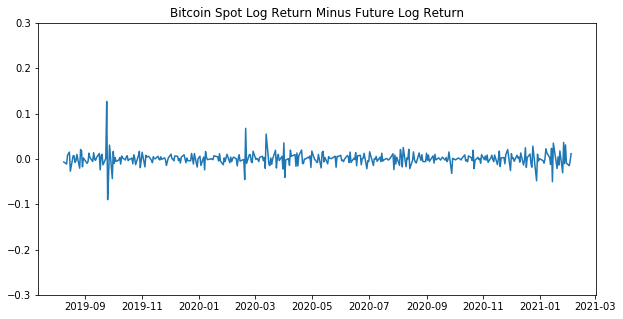

In [12]:
plt.figure(figsize=(10,5))
plt.plot(rf_df.Date, rs_df.rs-rf_df.rf)

plt.ylim((-0.3,0.3))

plt.title('Bitcoin Spot Log Return Minus Future Log Return')
plt.savefig('plots/BTC_minus_future_return.png', transparent=True)

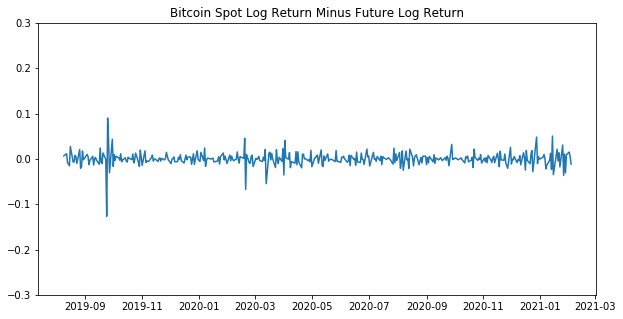

In [13]:
plt.figure(figsize=(10,5))
plt.plot(rf_df.Date, rf_df.rf-rs_df.rs)

plt.ylim((-0.3,0.3))

plt.title('Bitcoin Spot Log Return Minus Future Log Return')
plt.savefig('plots/future_minus_BTC_return.png', transparent=True)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


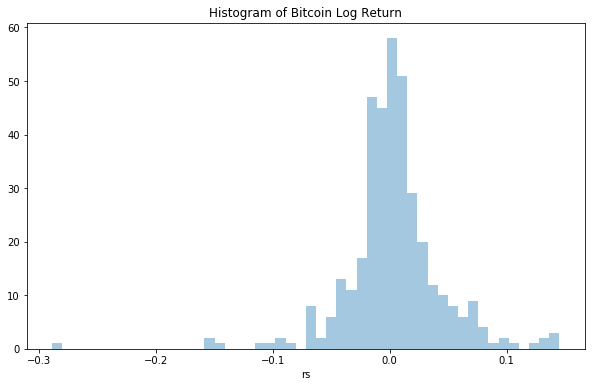

In [14]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.distplot(rs_df.rs, kde=False)
plt.title('Histogram of Bitcoin Log Return')
plt.savefig('plots/Histogram_BTC.png', transparent=True)

Text(0, 0.5, 'Future')

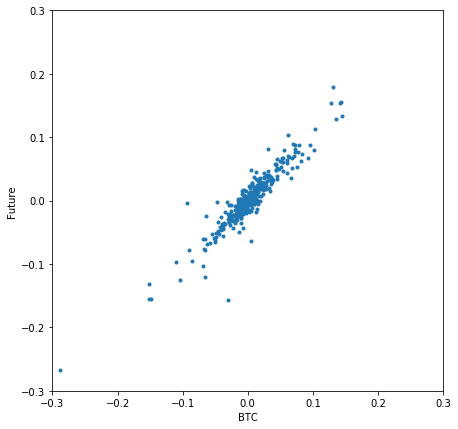

In [15]:
plt.figure(figsize=(7,7))

plt.scatter(rs_df.rs, rf_df.rf, marker='.')
plt.xlim((-0.3,0.3))
plt.ylim((-0.3,0.3))
plt.xlabel("BTC")
plt.ylabel("Future")

In [16]:
u = ECDF(rs_df.rs)(rs_df.rs)
v = ECDF(rf_df.rf)(rf_df.rf)

Text(0, 0.5, 'Future')

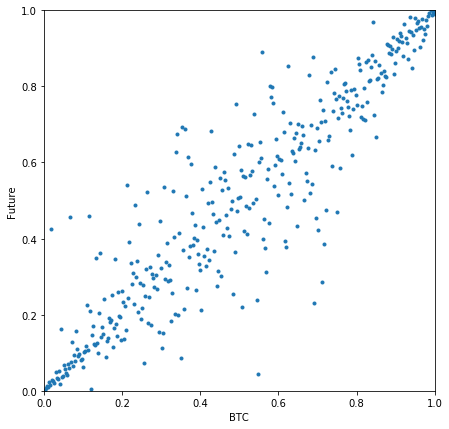

In [17]:
plt.figure(figsize=(7,7))

plt.scatter(u, v, marker='.')
plt.xlim((0,1))
plt.ylim((0,1))
plt.xlabel("BTC")
plt.ylabel("Future")

In [42]:
# C = Copula_names[0]
results = {}

for C in Copula_names:
    for rm in risk_measures:
        id_C = OHR_to_math.copula == C
        id_rm = OHR_to_math.risk_measure == rm


        df = OHR_to_math.loc[id_C&id_rm, :]
        df.reset_index(inplace=True, drop=True)

        rh_arr = []
        rs_arr = []
        rf_arr = []

        Date_arr = []

        for i in range(len(df)):
            h = df.iloc[i,:].OHR
            test = pd.read_csv(data_path+df.iloc[i,:].file_name)
            Date = test.Date
            rs = test.loc[:, 'log return bitcoin']
            rf = test.loc[:, 'log return future']
            rh = rs - h*rf
            rh_arr.append(rh)
            Date_arr.append(Date)

            rs_arr.append(rs)
            rf_arr.append(rf)
            
        rh_df = pd.DataFrame({'Date':np.array(Date_arr).reshape((-1)), 'rh':np.array(rh_arr).reshape((-1))})
        rs_df = pd.DataFrame({'Date':np.array(Date_arr).reshape((-1)), 'rs':np.array(rs_arr).reshape((-1))})
        rf_df = pd.DataFrame({'Date':np.array(Date_arr).reshape((-1)), 'rf':np.array(rf_arr).reshape((-1))})
        
        rh_df.Date = pd.to_datetime(rh_df.Date)
        rs_df.Date = pd.to_datetime(rs_df.Date)
        rf_df.Date = pd.to_datetime(rf_df.Date)
        
        # sort Date to make sure the cumulative sum is correct (sort from old data to new data)
        rh_df = rh_df.sort_values('Date', ascending=True).reset_index( drop=True)
        rs_df = rs_df.sort_values('Date', ascending=True).reset_index( drop=True)
        rf_df = rf_df.sort_values('Date', ascending=True).reset_index( drop=True)
      
        rh_df.loc[:,'cumsum'] = np.cumsum(rh_df.rh)
        rs_df.loc[:,'cumsum'] = np.cumsum(rs_df.rs)
        rf_df.loc[:,'cumsum'] = np.cumsum(rf_df.rf)
        
        investment = 1
        income_rh = investment*np.exp(rh_df.loc[:,'cumsum'])
        income_rs = investment*np.exp(rs_df.loc[:,'cumsum'])
        income_rf = investment*np.exp(rf_df.loc[:,'cumsum'])
    
#         results[(C, rm)] = income_rh
        results[(C, rm)] = rh_df.rh

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


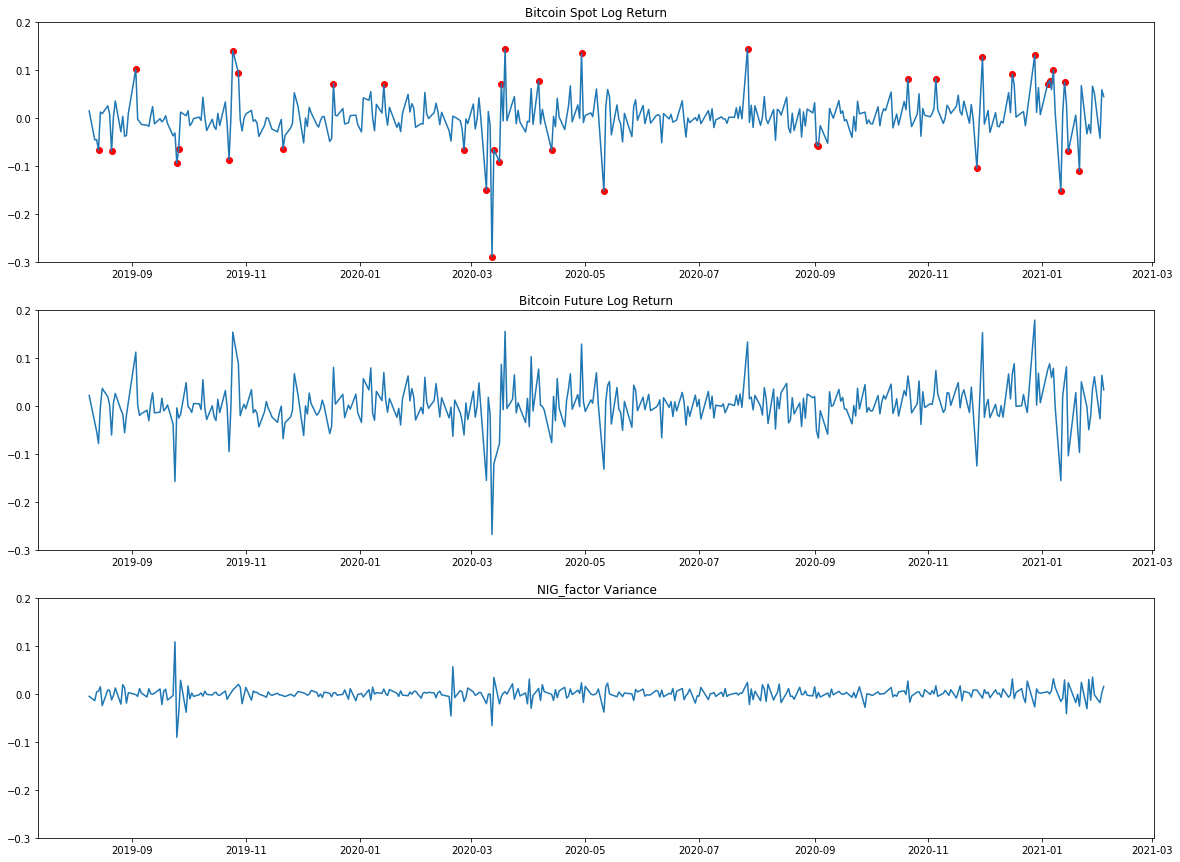

In [72]:
fig, axs = plt.subplots(3, 1, figsize=(20,15))

axs[0].plot(rs_df.Date, rs_df.rs)
axs[1].plot(rs_df.Date, rf_df.rf)
axs[2].plot(rs_df.Date, pd.DataFrame(results).Gaussian.iloc[:,0])


for ax in axs:
    ax.set_ylim((-.3,.2))


up_i = rs_df.rs > np.quantile(rs_df.rs, 0.95)
axs[0].scatter(rs_df.Date.loc[up_i], rs_df.rs.loc[up_i], color='r')

low_i = rs_df.rs < np.quantile(rs_df.rs, 0.05)
axs[0].scatter(rs_df.Date.loc[low_i], rs_df.rs.loc[low_i], color='r')


axs[0].set_title('Bitcoin Spot Log Return')
axs[1].set_title('Bitcoin Future Log Return')
axs[2].set_title('%s %s'%(C, rm))

plt.savefig('../latex/_pics/OOSreturns_compare.pdf', transparent=True)



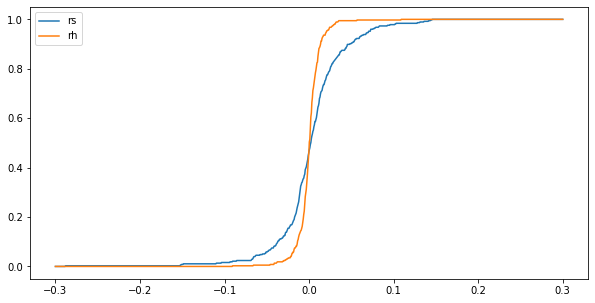

In [88]:
plt.figure(figsize=(10,5))
rh = pd.DataFrame(results).Gaussian.iloc[:,0] # Gaussian Variance

x = np.linspace(-.3,.3,1000)

ecdf_rs = ECDF(rs_df.rs)(x)
ecdf_rf = ECDF(rf_df.rf)(x)
ecdf_rh = ECDF(rh)(x)

plt.plot(x, ecdf_rs, label='rs')
plt.plot(x, ecdf_rh, label='rh')

plt.legend()

In [89]:
S_rs = np.cumsum(ecdf_rs)
S_rf = np.cumsum(ecdf_rf)
S_rh = np.cumsum(ecdf_rh)

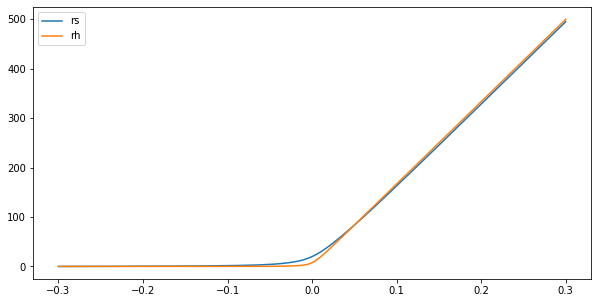

In [90]:
plt.figure(figsize=(10,5))

plt.plot(x, S_rs, label='rs')
plt.plot(x, S_rh, label='rh')

# plt.xlim((0.1,0.3))
plt.legend()